# data-preprocessing

Preprocessing procedures for raw data.

Warning: can eat up to 16 GB RAM while processing and filtering raw OSM data.

Requires:
1. `data/raw/osm.zip` (can be downloaded [here](https://drive.google.com/drive/folders/1Z_oSs5Vk4LSxwjc10iVa9mazBvWHuCf6?usp=sharing))
2. `data/raw/spb_routes.csv`

Produces:
1. `data/preprocessed/infrastructure.json`
2. `data/preprocessed/stops.json`
3. `data/preprocessed/routes.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
import json
from itertools import chain
from typing import Tuple, List, Optional, Set
from zipfile import ZipFile

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from cartopy import crs as ccrs
from tqdm import tqdm
from matplotlib import pyplot as plt

from myutils.spatial import get_earth_distances
from myutils.json import save_json
from myutils.matplotlib import matplotlib_latex, matplotlib_seaborn_style

from config import raw_osm_data_fpath, raw_routes_data_fpath, \
    infrastructure_fpath, stops_fpath, routes_fpath
from cartopy_config import whole_area, city_center, get_node_props
from ptn.osm import assign_infrastructure_types
from ptn.cartopy import add_map_subplot

matplotlib_seaborn_style()
matplotlib_latex()

## SPb routes

In [ ]:
raw_routes = pd.read_csv(raw_routes_data_fpath, encoding='utf-8')

raw_routes = raw_routes.rename(columns={'route_id': 'id', 'route_short_name': 'name',
                                        'transport_type': 'type'})

raw_routes['type'] = raw_routes['type'].map(
    {'Автобус': 'bus', 'Трамвай': 'tram', 'Троллейбус': 'trolley'})

raw_routes['lat'] = raw_routes['coordinates'].apply(lambda x: float(x.split(',')[0]))
raw_routes['lon'] = raw_routes['coordinates'].apply(lambda x: float(x.split(',')[1]))

raw_routes.head(2)

In [ ]:
stops = raw_routes.drop_duplicates('stop_id')\
    .drop(columns=['id', 'name'])\
    .rename(columns={'stop_id': 'id', 'stop_name': 'name'})\
    .reset_index(drop=True)

stops.head(2)

In [ ]:
routes = []

for route_id in tqdm(raw_routes['id'].unique()):
    for direction in raw_routes.loc[raw_routes['id'] == route_id, 'direction'].unique():
        mask = (raw_routes['id'] == route_id) & (raw_routes['direction'] == direction)
        raw_route = raw_routes[mask]
        
        assert raw_route['type'].nunique() == 1
        route_type = raw_route.iloc[0]['type']

        assert raw_route['name'].nunique() == 1
        name = raw_route.iloc[0]['name']
        
        assert raw_route['stop_id'].nunique() == raw_route.shape[0]

        next_stops = raw_route.set_index('stop_id')['next_stop']

        start = set(next_stops.index) - set(next_stops.values)
        
        if len(start) == 0:
            assert set(next_stops.index) == set(next_stops.values)  # circular route
            
            start = next_stops.index[0]
            route = [start]
            
            while True:
                next_ = next_stops[route[-1]]
                
                if next_ in route:
                    break
                    
                route.append(next_)
        
        else:
            assert len(start) == 1
            start = start.pop()

            route = [start]

            while route[-1] in next_stops.index:
                route.append(next_stops[route[-1]])

        routes.append({
            'name': name,
            'type': route_type,
            'direction': direction,
            'stops': route,
            'id': route_id,
        })
        
routes = pd.DataFrame(routes)

routes.head(2)

In [ ]:
route_stops = set(chain.from_iterable(routes['stops']))
stops_ = set(stops['id'].unique())

missing_stops = route_stops - stops_

len(missing_stops)

In [ ]:
def remove_missing_stops(route: List[int]) -> List[int]:
    missing = set(route).intersection(missing_stops)
    
    if len(missing) == 0:
        return route
    
    assert len(missing) == 1
    missing = missing.pop()
    assert route.index(missing) == len(route) - 1
    
    return route[:-1]


routes['stops'] = routes['stops'].apply(remove_missing_stops)

routes.head(2)

## OSM

In [ ]:
with ZipFile(raw_osm_data_fpath) as zipfile:
    raw_osm = []

    for fname in zipfile.namelist():
        with zipfile.open(fname, ) as file:
            raw_osm.extend(json.load(file)['elements'])

raw_osm = pd.DataFrame(raw_osm)

raw_osm = raw_osm.drop_duplicates(['type', 'id'])

raw_osm.head(2)

In [ ]:
raw_osm['type'].shape

In [ ]:
x0, y0 = stops[['lon', 'lat']].min()
x1, y1 = stops[['lon', 'lat']].max()

# padding out by about 10 km each way
xpad = (x1 - x0) / 25
ypad = (y1 - y0) / 7

x0 -= xpad
x1 += xpad
y0 -= ypad
y1 += ypad

x0, x1, y0, y1

In [ ]:
mask = (raw_osm['lon'].isna() | ((raw_osm['lon'] >= x0) & (raw_osm['lon'] <= x1)))\
    & (raw_osm['lat'].isna() | ((raw_osm['lat'] >= y0) & (raw_osm['lat'] <= y1)))

raw_osm = raw_osm[mask].copy()

raw_osm.head(2)

In [ ]:
raw_osm['type'].shape

In [ ]:
raw_osm['type'].value_counts()

In [ ]:
node_coords = raw_osm.loc[raw_osm['type'] == 'node', ['id', 'lat', 'lon']].set_index('id')
assert node_coords.notna().all().all()

node_coords = dict(zip(node_coords.index.tolist(), map(tuple, node_coords.values.tolist())))

### Infrastructure objects

In [ ]:
raw_osm['infrastructure_types'] = raw_osm['tags'].apply(assign_infrastructure_types)
raw_osm['n_infrastructure_types'] = raw_osm['infrastructure_types'].apply(len)

raw_osm['n_infrastructure_types'].value_counts()

In [ ]:
mask = (raw_osm['n_infrastructure_types'] > 0) & (raw_osm['type'] != 'relation')

infrastructure = raw_osm[mask].copy()

infrastructure.head(2)

In [ ]:
def get_name(tags: dict) -> str:
    if not isinstance(tags, dict):
        return
    
    name = tags.get('official_name', tags.get('name:ru', tags.get('name')))
    
    return name


infrastructure['name'] = infrastructure['tags'].apply(get_name)

infrastructure.head(2)

In [ ]:
all_nodes = set(node_coords.keys())

mask = infrastructure['nodes'].notna()
n_items = mask.sum()

to_remove = []

for i, row in tqdm(infrastructure[mask].iterrows(), total=n_items):
    nodes = set(row['nodes'])
    
    if len(nodes - all_nodes) > 0:
        to_remove.append(i)
        continue
    
    coords = np.array([node_coords[node] for node in nodes])
    lat, lon = coords.mean(axis=0)
    infrastructure.loc[i, 'lat'] = lat
    infrastructure.loc[i, 'lon'] = lon
    
    distances = get_earth_distances(coords, coords)
    diameter = distances.max()
    infrastructure.loc[i, 'diameter'] = diameter
    
infrastructure = infrastructure.drop(index=to_remove)

infrastructure['diameter'] = infrastructure['diameter'].fillna(0)

infrastructure.shape

In [ ]:
(infrastructure['diameter'] > 0.25).mean()

In [ ]:
infrastructure.sort_values(by='diameter', ascending=False).iloc[0]['tags']

In [ ]:
assert infrastructure[['lat', 'lon']].notna().all().all()
assert infrastructure['id'].nunique() == infrastructure.shape[0]

In [ ]:
stop_coords = stops[['lat', 'lon']].values

infrastructure_coords = infrastructure[['lat', 'lon']]

distances = pd.Series({
    i: get_earth_distances(coords.values.reshape(1, -1), stop_coords).min()
    for i, coords in tqdm(infrastructure_coords.iterrows(), total=infrastructure_coords.shape[0])
})

to_remove = distances[distances > 2].index

infrastructure = infrastructure.drop(index=to_remove)

infrastructure.shape

In [ ]:
infrastructure_json = infrastructure\
    .drop(columns=['type', 'tags', 'nodes', 'members', 'n_infrastructure_types'])\
    .rename(columns={'infrastructure_types': 'types'})

infrastructure_json = [row.to_dict() for _, row in infrastructure_json.iterrows()]

len(infrastructure_json)

In [ ]:
infrastructure_json[0]

In [ ]:
save_json(infrastructure_json, infrastructure_fpath)

In [9]:
infrastructure = pd.read_json(infrastructure_fpath, encoding='utf-8').set_index('id')

infrastructure.head(2)

,lat,lon,types,name,diameter
id,,,,,
267959524,59.661098,30.785173,[Tourism],Саблинский водопад,0.0
268911313,59.688758,29.920383,[Car service],Киришиавтосервис 13,0.0


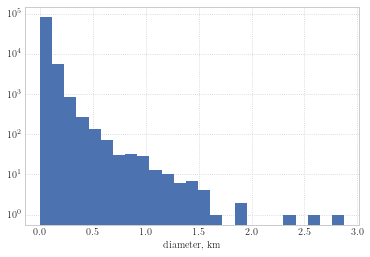

In [10]:
plt.hist(infrastructure['diameter'], bins=25)

plt.yscale('log')
plt.xlabel('diameter, km')
plt.savefig('../figures/infrastructure_diameters.pdf', transparent=True, bbox_inches='tight')

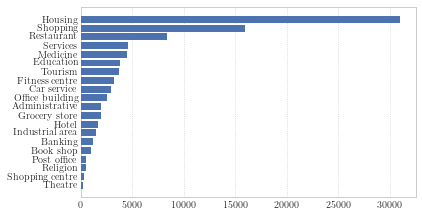

In [12]:
plt.figure(figsize=(6, 3.5))

infrastructure_types = pd.Series(chain.from_iterable(infrastructure['types']))
infrastructure_type_counts = infrastructure_types.value_counts().sort_values()

plt.barh(
    infrastructure_type_counts.index,
    infrastructure_type_counts.values,
    zorder=5,
)

plt.grid(axis='y')

plt.savefig('../figures/infrastructure_counts.pdf', transparent=True, bbox_inches='tight')

### Subway stations

In [ ]:
def is_subway_entrance(tags: dict) -> bool:
    return isinstance(tags, dict) and tags.get('railway') == 'subway_entrance'


def get_subway_line_color(tags: dict) -> str:
    return tags.get('colour')


raw_osm['is_subway_entrance'] = raw_osm['tags'].apply(is_subway_entrance)

mask = raw_osm['is_subway_entrance'] & (raw_osm['type'] == 'node')
subway_entrances = raw_osm[mask].copy()

subway_entrances['name'] = subway_entrances['tags'].apply(get_name)
subway_entrances['line_color'] = subway_entrances['tags'].apply(get_subway_line_color)

subway_entrances.head(2)

In [ ]:
station_names = ['Автово', 'Адмиралтейская', 'Академическая', 'Балтийская',
                 'Беговая', 'Бухарестская', 'Василеостровская', 'Владимирская',
                 'Волковская', 'Выборгская', 'Горьковская', 'Гостиный двор',
                 'Гражданский проспект', 'Достоевская', 'Дунайская', 'Елизаровская',
                 'Звенигородская', 'Звёздная', 'Зенит', 'Кировский завод',
                 'Комендантский проспект', 'Крестовский остров', 'Купчино',
                 'Ладожская', 'Ленинский проспект', 'Лесная', 'Лиговский проспект',
                 'Ломоносовская', 'Маяковская', 'Международная', 'Московская',
                 'Московские ворота', 'Нарвская', 'Невский проспект',
                 'Новочеркасская', 'Обводный канал', 'Обухово', 'Озерки',
                 'Парк Победы', 'Парнас', 'Петроградская', 'Пионерская',
                 'Площадь Александра Невского', 'Площадь Восстания', 'Площадь Ленина',
                 'Площадь Мужества', 'Политехническая', 'Приморская', 'Пролетарская',
                 'Проспект Большевиков', 'Проспект Ветеранов', 'Проспект Просвещения',
                 'Проспект Славы', 'Пушкинская', 'Рыбацкое', 'Садовая',
                 'Сенная площадь', 'Спасская', 'Спортивная', 'Старая Деревня',
                 'Технологический институт', 'Удельная', 'Улица Дыбенко',
                 'Фрунзенская', 'Чернышевская', 'Чкаловская', 'Чёрная речка',
                 'Шушары', 'Электросила', 'Девяткино']


def get_station_name(entrance_name: str) -> str:
    suitable_station_names = [name for name in station_names if entrance_name.startswith(name)]
    
    if len(suitable_station_names) != 1:
        raise ValueError('multiple or no station names for entrance ' + repr(entrance_name))
        
    return suitable_station_names[0]


subway_entrances['station_name'] = subway_entrances['name'].apply(get_station_name)

subway_entrances.head(2)

In [ ]:
assert subway_entrances['line_color'].notna().all()
assert subway_entrances['station_name'].notna().all()

In [ ]:
line_starts = {
    'blue': 'Парнас',
    'red': 'Девяткино',
    'green': 'Беговая',
    'orange': 'Улица Дыбенко',
    'purple': 'Комендантский проспект',
}

In [ ]:
subway_stations = []

for line_color, station_name in subway_entrances[['line_color', 'station_name']].drop_duplicates().values:
    mask = (subway_entrances['line_color'] == line_color)\
        & (subway_entrances['station_name'] == station_name)
    
    station_entrances = subway_entrances[mask]
    coords = station_entrances[['lat', 'lon']].values
    lat, lon = coords.mean(axis=0)
    
    diameter = get_earth_distances(coords, coords).max()
    
    subway_stations.append({
        'line_color': line_color,
        'name': station_name,
        'lat': lat,
        'lon': lon,
        'diameter': diameter,
        'start': line_starts[line_color] == station_name,
    })
    
subway_stations = pd.DataFrame(subway_stations)

subway_stations['name'] = subway_stations['name'] + ' (' + subway_stations['line_color'] + ')'
subway_stations['id'] = subway_stations.index.tolist()
subway_stations['type'] = 'subway'

subway_stations.head(2)

In [ ]:
for color in subway_stations['line_color'].unique():
    values = subway_stations\
        .loc[subway_stations['line_color'] == color, ['lon', 'lat']]\
        .values
    
    plt.scatter(*values.T, color=color)
    
plt.axis('off')

### Subway routes

In [ ]:
subway_routes = []

for color in subway_stations['line_color'].unique():
    line_stations = subway_stations[subway_stations['line_color'] == color]
    n_stations = line_stations.shape[0]
    
    coords = line_stations[['lat', 'lon']].values
    distances = get_earth_distances(coords, coords)
    distances[np.arange(n_stations), np.arange(n_stations)] = np.infty
    distances = pd.DataFrame(distances, index=line_stations['id'], columns=line_stations['id'])
    
    start = line_stations.loc[line_stations['start'], 'id']
    assert start.shape == (1,)
    start = start.iloc[0]
    
    route = [start]
        
    while True:
        closest_unvisited = distances\
            .loc[route[-1], ~distances.index.isin(route)]\
            .sort_values()
        
        if closest_unvisited.empty:
            break
        
        next_ = closest_unvisited.index[0]
        route.append(next_)
        
    name = color.capitalize() + ' line'
        
    subway_routes.append({
        'name': name,
        'type': 'subway',
        'direction': 1,
        'stops': route,
    })
    subway_routes.append({
        'name': name,
        'type': 'subway',
        'direction': 2,
        'stops': route[::-1],
    })
    
subway_routes = pd.DataFrame(subway_routes)

subway_routes['id'] = subway_routes.index.tolist()

subway_routes.head(2)

## All stops and routes together

In [38]:
all_stops = stops.append(subway_stations, ignore_index=True)\
    .drop(columns=['number', 'route_long_name', 'next_stop', 'direction',
                   'stop_distance', 'coordinates', 'line_color', 'start'])

all_stops['diameter'] = all_stops['diameter'].fillna(0)

all_stops.head(2)

NameError: name 'stops' is not defined

In [ ]:
assert all_stops.notna().all().all()
assert all_stops['id'].nunique() == all_stops.shape[0]

In [39]:
all_routes = routes.append(subway_routes, ignore_index=True)

all_routes['stops'] = all_routes['stops'].apply(lambda l: [int(i) for i in l])

all_routes.head(2)

NameError: name 'routes' is not defined

In [40]:
stop2id = {stop: i for i, stop in all_stops['id'].iteritems()}

coords = all_stops[['lat', 'lon']].values
distances = get_earth_distances(coords, coords)


def get_route_distance(route: List[int]) -> float:
    i = [stop2id[stop] for stop in route]
    distance = distances[i[:-1], i[1:]].sum()
    
    return distance


all_routes['distance'] = all_routes['stops'].apply(get_route_distance)

all_routes.head(2)

KeyError: 'id'

In [ ]:
assert not all_routes.duplicated(['id', 'direction']).any()

In [ ]:
assert all_routes['id'].max() < 10000

all_routes.loc[all_routes['direction'] == 2, 'id'] += 10000

all_routes.head(2)

In [ ]:
assert all_routes['id'].nunique() == all_routes.shape[0]

In [ ]:
assert all_routes.notna().all().all()

In [ ]:
route_stops = set(chain.from_iterable(all_routes['stops']))
stops_ = set(all_stops['id'].unique())

missing_stops = route_stops - stops_

assert len(missing_stops) == 0

In [ ]:
all_stops_json = [row.to_dict() for _, row in all_stops.iterrows()]

len(all_stops_json)

In [ ]:
all_stops_json[0]

In [ ]:
save_json(all_stops_json, stops_fpath)

In [ ]:
all_routes_json = [row.to_dict() for _, row in all_routes.iterrows()]

len(all_routes_json)

In [ ]:
all_routes_json[0]

In [ ]:
save_json(all_routes_json, routes_fpath)

***

In [3]:
all_stops = pd.read_json(stops_fpath, encoding='utf-8').set_index('id')

stop_coords = all_stops[['lon', 'lat']]

stop_coords.head(2)

,lon,lat
id,,
16396,30.494671,59.908881
16367,30.499882,59.911857


In [4]:
all_routes = pd.read_json(routes_fpath, encoding='utf-8').set_index('id')

all_routes.head(2)

,name,type,direction,stops,distance,supernodes
id,,,,,,
1125,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",5.008430,"[620, 827, 828, 20, 309, 80, 310, 204, 5, 29, ..."
11125,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",3.826103,"[30, 829, 830, 621, 311, 831, 14, 81, 620]"


In [5]:
nstops = all_stops.groupby('type')['name'].count().astype(int)
nstops.name = 'Number of stops'

nroutes = all_routes.groupby('type')['name'].count().astype(int)
nroutes.name = 'Number of routes'

routelen = all_routes.groupby('type')['distance'].mean().round(2)
routelen.name = 'Avg. route length, km'

stats = pd.DataFrame([nstops, nroutes, routelen], dtype='object')

stats.columns.name = None

stats.head()

,bus,subway,tram,trolley
Number of stops,5511.0,71.0,887.0,1192.0
Number of routes,1070.0,10.0,83.0,90.0
"Avg. route length, km",14.15,24.02,10.38,11.32


In [6]:
with open('../tables/transport_stats.tex', 'w') as file:
    file.write(stats.to_latex())

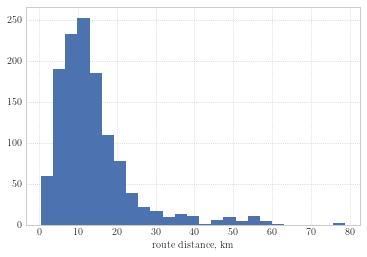

In [7]:
all_routes['distance'].hist(bins=25)

plt.xlabel('route distance, km')

plt.savefig('../figures/route_distances.pdf', transparent=True, bbox_inches='tight')

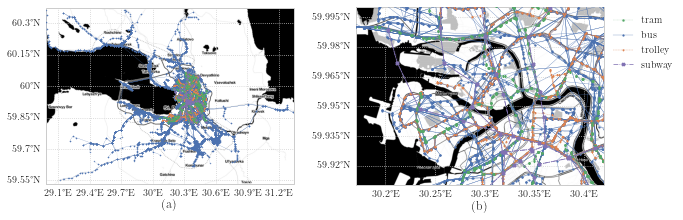

In [7]:
fig = plt.figure(figsize=(10, 4))

extent, scale, factor = whole_area

ax = add_map_subplot(fig, 1, 2, 1, extent=extent, scale=scale)

for t in all_routes['type'].unique():
    type_routes = all_routes[all_routes['type'] == t].copy()
    
    color, marker, size, width, linestyle, zorder = get_node_props(t, factor)
        
    for i, route in enumerate(type_routes['stops']):
        x, y = stop_coords.loc[route].values.T
        
        label = t if i == 0 else None
        
        ax.plot(x, y, transform=ccrs.PlateCarree(), marker=marker, markersize=size,
                lw=width, ls=linestyle, c=color, label=label, zorder=zorder)
            
ax.set_title('(a)', y=-0.17)

extent, scale, factor = city_center

ax = add_map_subplot(fig, 1, 2, 2, extent=extent, scale=scale)

for t in all_routes['type'].unique():
    type_routes = all_routes[all_routes['type'] == t].copy()
    
    color, marker, size, width, linestyle, zorder = get_node_props(t, factor)
    
    for i, route in enumerate(type_routes['stops']):
        x, y = stop_coords.loc[route].values.T
        
        label = t if i == 0 else None
        
        ax.plot(x, y, transform=ccrs.PlateCarree(), marker=marker, markersize=size,
                lw=width, ls=linestyle, c=color, label=label, zorder=zorder)
            
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('(b)', y=-0.17)

fig.subplots_adjust(wspace=0.25)

plt.savefig('../figures/stops_map.png', dpi=250, transparent=True, bbox_inches='tight')